## Comparing the analytical derivative and numerical derivative. Testing the imfact from them to EM scheme.

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
import sympy
%matplotlib inline
plt.style.use('bmh')
import scipy
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [2]:
import sympy
z = sympy.symbols('z')
K0 = 1e-6
K1 = 6e-3# m / s
Aalpha = 0.5
w=0

sym_Difty =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dDdz = sympy.diff(sym_Difty, z, 1)

Difty  =  sympy.utilities.lambdify(z, sym_Difty,np)
dDdz   =  sympy.utilities.lambdify(z,          sym_dDdz,np)
del z

def K(z):
    return np.where(z<0, Difty(-z), Difty(z))

def dKdz(z):
    return np.where(z<0, -dDdz(-z), dDdz(z))

In [3]:
def step_e_finite(z,H,dt,N_sample):
    dz = 2.5e-3
    dW = np.random.normal(0,np.sqrt(dt),N_sample)
    a = (K(z+dz)-K(z-dz)) / (2*dz)
    b = np.sqrt(2 * K(z))
    temp = z + a * dt + b * dW
    return temp 

def step_e(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=dKdz(z)
    b=np.sqrt(2*K(z))
    temp=z+a*dt+b*dW
    return temp

def step_e_Const(z,H,dt,N_sample):

    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    a=0
    b=np.sqrt(2*3e-3)
    temp=z+a*dt+b*dW
    return temp

In [4]:
def oneStep1(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (0 > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel1(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.random.uniform(0 , H, int(Np))

    for i in range(Ntime):

        z, Cross, Land = oneStep1( z,    scheme,         H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins = np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0
        
        temp2, _ = np.histogram(Cross, bins = np.linspace(0, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2
        
        temp3, _ = np.histogram(Land, bins = np.linspace(0, Testdepth, Nbins))
        hist_Land = hist_Land + temp3 

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    
    return None
        
def RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel1, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()

    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np * dz * (Ntime + 1))
    
    return hist_, hist_Cross, hist_Land

In [5]:
def oneStep2(Z ,scheme, H, dt):
    
    Z_Origin = Z.copy()
    Z = scheme(Z, H, dt, Z.size)
    
    maskCross = ((H < Z) | (-H > Z))
    Crossing = Z_Origin[maskCross]
    
    Z = np.where(Z < -H, -2*H -Z, Z)
    Z = np.where(Z > H, 2*H - Z, Z)
    
    Landing = Z[maskCross]
    
    return Z, Crossing, Landing

def parallel2(Tmax, dt, H, Testdepth, Np, Nbins, quene, queneCross, queneLand, scheme):
    
    np.random.seed()
    Ntime   =int(Tmax/dt)

    hist_ = np.zeros((Nbins-1,),'i')
    hist_Cross = np.zeros((Nbins-1,),'i')
    hist_Land = np.zeros((Nbins-1,),'i')

    z = np.random.uniform(-H , H,int(Np))

    for i in range(Ntime):

        z, Cross, Land = oneStep2( z,    scheme,         H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins = np.linspace(-Testdepth, Testdepth, Nbins))
        hist_ = hist_ + temp0
        
        temp2, _ = np.histogram(Cross, bins = np.linspace(-Testdepth, Testdepth, Nbins))
        hist_Cross = hist_Cross + temp2
        
        temp3, _ = np.histogram(Land, bins = np.linspace(-Testdepth, Testdepth, Nbins))
        hist_Land = hist_Land + temp3 

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    quene.put(hist_)
    queneCross.put(hist_Cross)
    queneLand.put(hist_Land)
    
    return None
        
def RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):
        
        threads=[]
        quene = mp.Queue()
        queneCross = mp.Queue()
        queneLand = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallel2, 
                                args= (Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                       quene, queneCross,
                                       queneLand, scheme))
            
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_  = np.zeros((Nbins-1,),'i')
    hist_Cross  = np.zeros((Nbins-1,),'i')
    hist_Land   = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_      += quene.get()
        hist_Cross += queneCross.get()
        hist_Land += queneLand.get()
        
    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np  * dz * (Ntime + 1))
    
    return hist_, hist_Cross, hist_Land

In [6]:
Np        = 40000
Nbins     = 2000
dt        = 10
Tmax      = dt*1*3600
H         = 10
Testdepth = H
NumberOfThread = 4

In [7]:
startTime = time()
EM, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)
endTime = time()
print("Time elapsed: ", endTime-startTime)

startTime = time()
EM_Const, _, _ = RunSimulation2(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e_Const)
endTime = time()
print("Time elapsed: ", endTime-startTime)


Total number of process:  4
Time elapsed:  13.211032390594482
Total number of process:  4
Time elapsed:  8.322124004364014


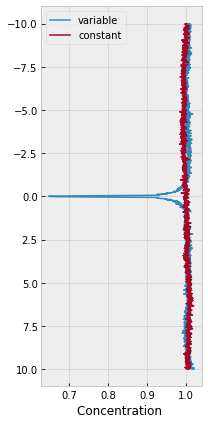

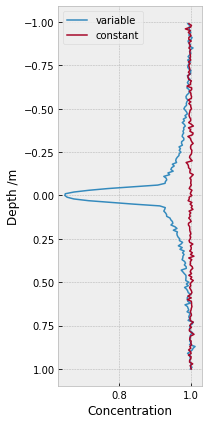

In [8]:
#
%matplotlib inline
bins = np.linspace(-Testdepth, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2
fig, ax = plt.subplots(ncols = 1, figsize = (3,6))
ax.plot(EM, midpoints, linewidth=1.5, label= "variable")
ax.plot(EM_Const, midpoints, linewidth=1.5, label= "constant")
ax.set_xlabel('Concentration ')
ax.invert_yaxis()
ax.legend()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(ncols = 1, figsize = (3,6))
ax.plot(EM[900:1100], midpoints[900:1100], linewidth=1.5, label= "variable")
ax.plot(EM_Const[900:1100], midpoints[900:1100], linewidth=1.5, label= "constant")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')

ax.invert_yaxis()
ax.legend()
plt.tight_layout()
plt.show()


In [9]:
startTime = time()
EM_Halve, _, _ = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np/2, Nbins, step_e)
endTime = time()
print("Time elapsed: ", endTime-startTime)

startTime = time()
EM_Const_Halve, _, _ = RunSimulation1(NumberOfThread, Tmax, dt, H, Testdepth, Np/2, Nbins, step_e_Const)
endTime = time()
print("Time elapsed: ", endTime-startTime)

Total number of process:  4
Time elapsed:  9.214636087417603
Total number of process:  4
Time elapsed:  5.692508220672607


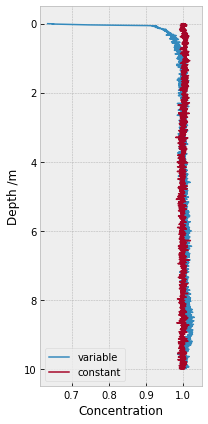

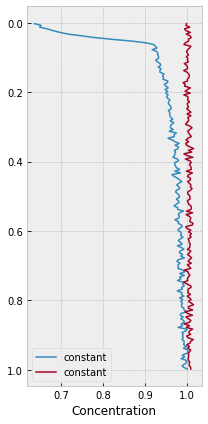

In [10]:
#
%matplotlib inline
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 1, figsize = (3,6))
ax.plot(EM_Halve, midpoints, linewidth=1.5, label= "variable")
ax.plot(EM_Const_Halve, midpoints, linewidth=1.5, label= "constant")
ax.set_xlabel('Concentration')
ax.set_ylabel('Depth /m')
ax.invert_yaxis()
ax.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols = 1, figsize = (3,6))
ax.plot(EM_Halve[0:200], midpoints[0:200], linewidth=1.5, label= "constant")
ax.plot(EM_Const_Halve[0:200], midpoints[0:200], linewidth=1.5, label= "constant")
ax.set_xlabel('Concentration')

ax.invert_yaxis()
ax.legend()
plt.tight_layout()
plt.show()


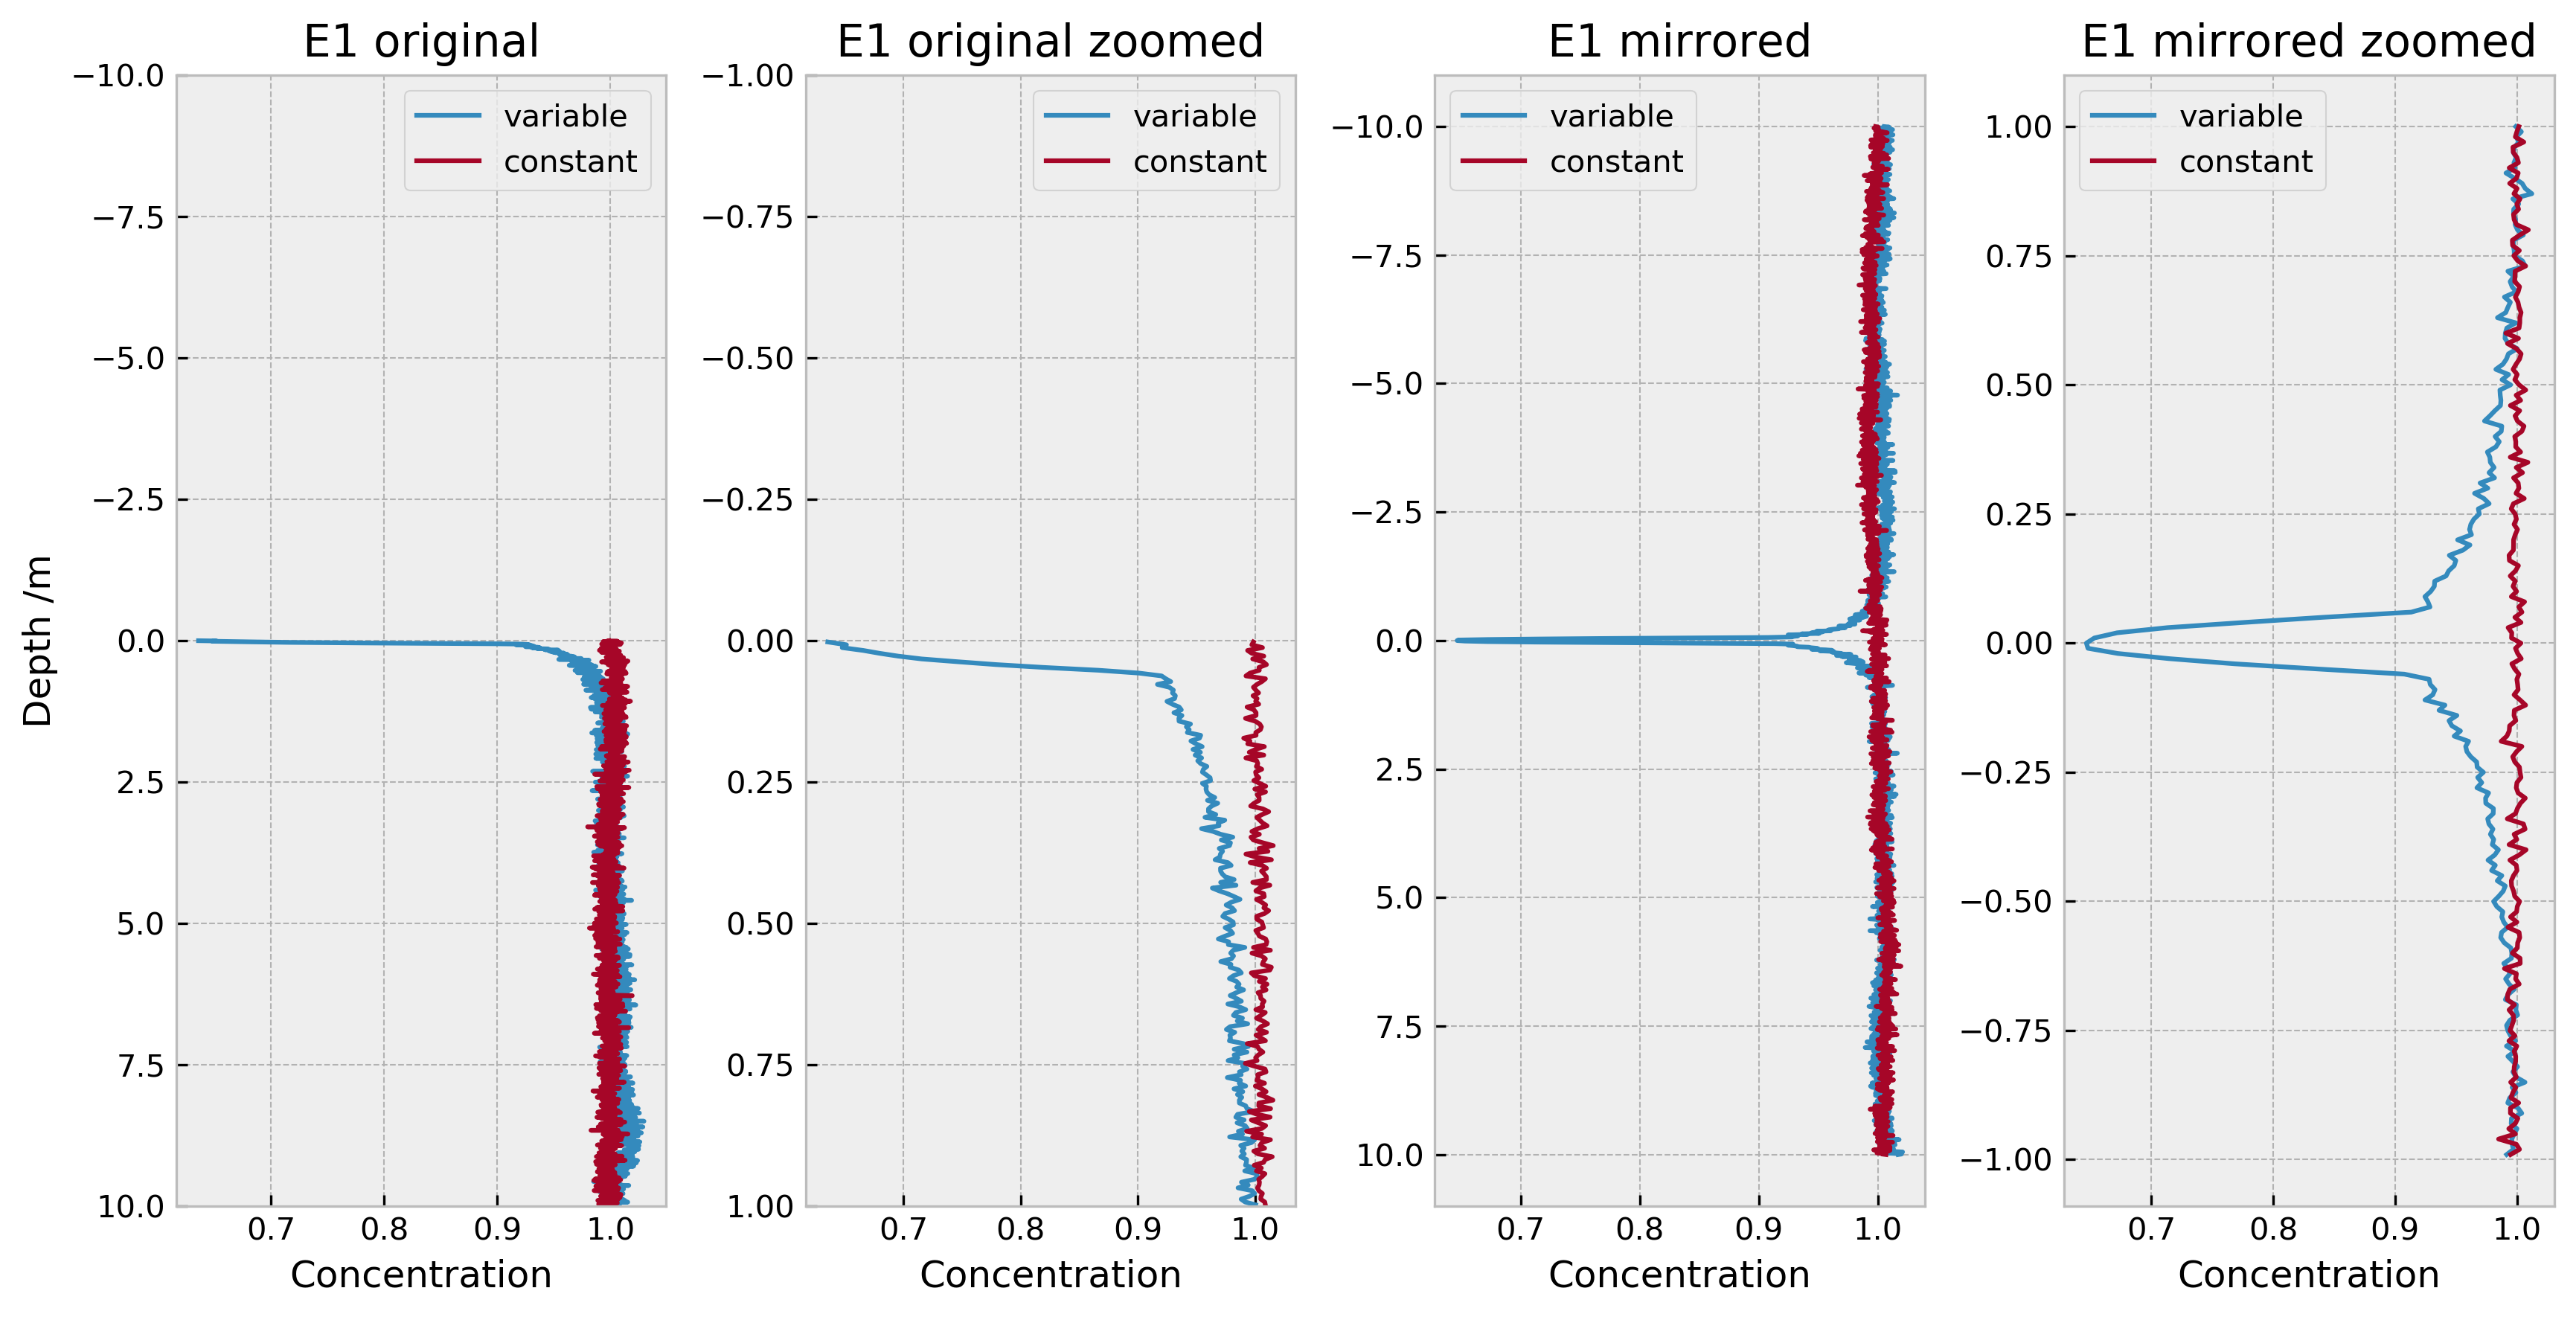

In [12]:
%matplotlib inline
bins = np.linspace(-Testdepth, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.68,6), dpi = 300)

ax[2].plot(EM, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(EM_Const, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concentration')
ax[2].set_title('E1 mirrored')
ax[2].invert_yaxis()
ax[2].legend()

ax[3].plot(EM[900:1100], midpoints[900:1100], linewidth=1.5, label= "variable")
ax[3].plot(EM_Const[900:1100], midpoints[900:1100], linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concentration')
ax[3].set_title('E1 mirrored zoomed')
ax[3].legend()

bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

ax[0].plot(EM_Halve, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(EM_Const_Halve, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1 original')
ax[0].set_ylim(-10,10)
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(EM_Halve[0:200], midpoints[0:200], linewidth=1.5, label= "variable")
ax[1].plot(EM_Const_Halve[0:200], midpoints[0:200], linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concentration')
ax[1].set_title('E1 original zoomed')
ax[1].set_ylim(-1,1)
ax[1].invert_yaxis()

ax[1].legend()
plt.tight_layout()
plt.show()